In [1]:
import numpy as np
import cytnx
import matplotlib.pyplot as plt
import cProfile
from scipy.optimize import curve_fit

In [2]:
def ut_print(ut,print_numpy = True):
    ut.print_diagram()
    if print_numpy:
        print(ut.get_block().numpy())

def get_M(T):
    W = np.array([[np.exp(1/T),np.exp(-1/T)],
                  [np.exp(-1/T),np.exp(1/T)]])
    W = cytnx.from_numpy(W)
    S,U,Vd = cytnx.linalg.Svd(W)
    M = U @ cytnx.linalg.Diag(S.Pow(0.5))
    M = cytnx.UniTensor(M, rowrank = 1)
    M.set_name('M')
    Md = cytnx.linalg.Diag(S.Pow(0.5)) @ Vd
    Md = cytnx.UniTensor(Md, rowrank = 1)
    Md.set_name('Md')
    return M,Md

def get_delta(h):
    delta = cytnx.zeros([2,2,2,2])
    delta[0,0,0,0] = 1
    delta[1,1,1,1] = 1
    delta = cytnx.UniTensor(delta, rowrank = 2)
    delta.set_name('delta')
    return delta

def get_T_baret(T,h=0):
    ut_M, ut_Md = get_M(T)
    ut_delta = get_delta(h)
    Ising_net = cytnx.Network('./Networks/Ising_square.net')
    Ising_net.PutUniTensors(['delta', 'M0.d', 'M1.d', 'M2', 'M3'],
                            [ut_delta, ut_Md, ut_Md, ut_M, ut_M])
    T_bare = Ising_net.Launch(optimal=True)
    T_bare.set_name('T_bare')
    return T_bare

def merge_y(Tup,Tdn, combine = False, trace = False):
    if trace:
        TupTdn_net = cytnx.Network('./Networks/merge_y_trace.net')
    else:
        TupTdn_net = cytnx.Network('./Networks/merge_y.net')
    TupTdn_net.PutUniTensors(['Tup', 'Tdn'],
                             [Tup, Tdn])
    TupTdn = TupTdn_net.Launch(optimal=True)
    if combine:
        TupTdn.combineBonds([1,2])
        TupTdn.combineBonds([3,4])
    return TupTdn

def merge_y_truncate(Tup, Tdn, dcut):
    if ((Tup.shape()[1]*Tdn.shape()[1]) < dcut):
        return merge_y(Tup, Tdn,True)
    TupTdn_pure_net = cytnx.Network('./Networks/merge_y_pure.net')
    TupTdn_pure_net.PutUniTensors(['Tup', 'Tdn','Tupd','Tdnd'],
                                  [Tup, Tdn,Tup,Tdn])
    TupTdn_pure = TupTdn_pure_net.Launch(optimal=True)
    _,U,__ = cytnx.linalg.Svd_truncate(TupTdn_pure,dcut)
    TupTdn_net = cytnx.Network('./Networks/merge_y_truncate.net')
    TupTdn_net.PutUniTensors(['Tup', 'Tdn','UL','UR'],
                             [Tup, Tdn,U,U])
    TupTdn = TupTdn_net.Launch(optimal=True)
    return TupTdn

def merge_x(TL,TR, combine = False, trace = False):
    if trace:
        n = TL.shape()[0]
        I = np.eye(n)
        I = cytnx.from_numpy(I)
        I = cytnx.UniTensor(I, rowrank = 1)
        TLTR_net = cytnx.Network('./Networks/merge_x_trace.net')
        TLTR_net.PutUniTensors(['TL', 'TR', 'IL', 'IR'],
                               [TL, TR, I, I])
        TLTR = TLTR_net.Launch(optimal=True)
    else:
        TLTR_net = cytnx.Network('./Networks/merge_x.net')
        TLTR_net.PutUniTensors(['TL', 'TR'],
                               [TL, TR])
        TLTR = TLTR_net.Launch(optimal=True)
    if combine and not trace:
        TLTR.combineBonds([0,1])
        TLTR.combineBonds([4,5])
    return TLTR

def merge_x_truncate(TL, TR, dcut):
    if ((TL.shape()[0]*TR.shape()[0]) < dcut):
        return merge_x(TL, TR,True)
    TLTR_pure_net = cytnx.Network('./Networks/merge_x_pure.net')
    TLTR_pure_net.PutUniTensors(['TL', 'TR','TLd','TRd'],
                                [TL, TR,TL,TR])
    TLTR_pure = TLTR_pure_net.Launch(optimal=True)
    try:
        _,U,__ = cytnx.linalg.Svd_truncate(TLTR_pure,dcut)
    except:
        TLTR_pure.print_diagram()
        _,U,__ = cytnx.linalg.Svd(TLTR_pure,dcut)
    TLTR_net = cytnx.Network('./Networks/merge_x_truncate.net')
    TLTR_net.PutUniTensors(['TL', 'TR','Uup','Udn'],
                           [TL, TR, U, U])
    TLTR = TLTR_net.Launch(optimal=True)
    return TLTR

def trace(T):
    n = T.shape()[0]
    I = np.eye(n)
    I = cytnx.from_numpy(I)
    I = cytnx.UniTensor(I, rowrank = 1)
    trace_net = cytnx.Network('./Networks/trace.net')
    trace_net.PutUniTensors(['T', 'I'],
                             [T, I])
    return trace_net.Launch(optimal=True)

# $N\times 1$

## MaxL = 10

In [3]:
MaxL = 10
Temp = np.linspace(2.26,2.38,200)
W = np.ones((MaxL+1,len(Temp),2))
Tc = 2/np.log(1+np.sqrt(2))

In [4]:
%%time
for i,temp in enumerate(Temp):
    #print(temp)
    T_bare = get_T_baret(temp)
    TL = T_bare
    for j in range(2,MaxL+1):
        TL_Trace = merge_y(TL,T_bare,True,True)
        w,v = cytnx.linalg.Eigh(TL_Trace.get_block())
        W[j,i,:] = w[-2:].numpy()
        TL = merge_y(TL,T_bare,True)
E = -np.log(W)
Corr_len = 1/(E[:,:,-2]-E[:,:,-1])

CPU times: user 1h 17min 15s, sys: 4min 23s, total: 1h 21min 39s
Wall time: 2min 40s


/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


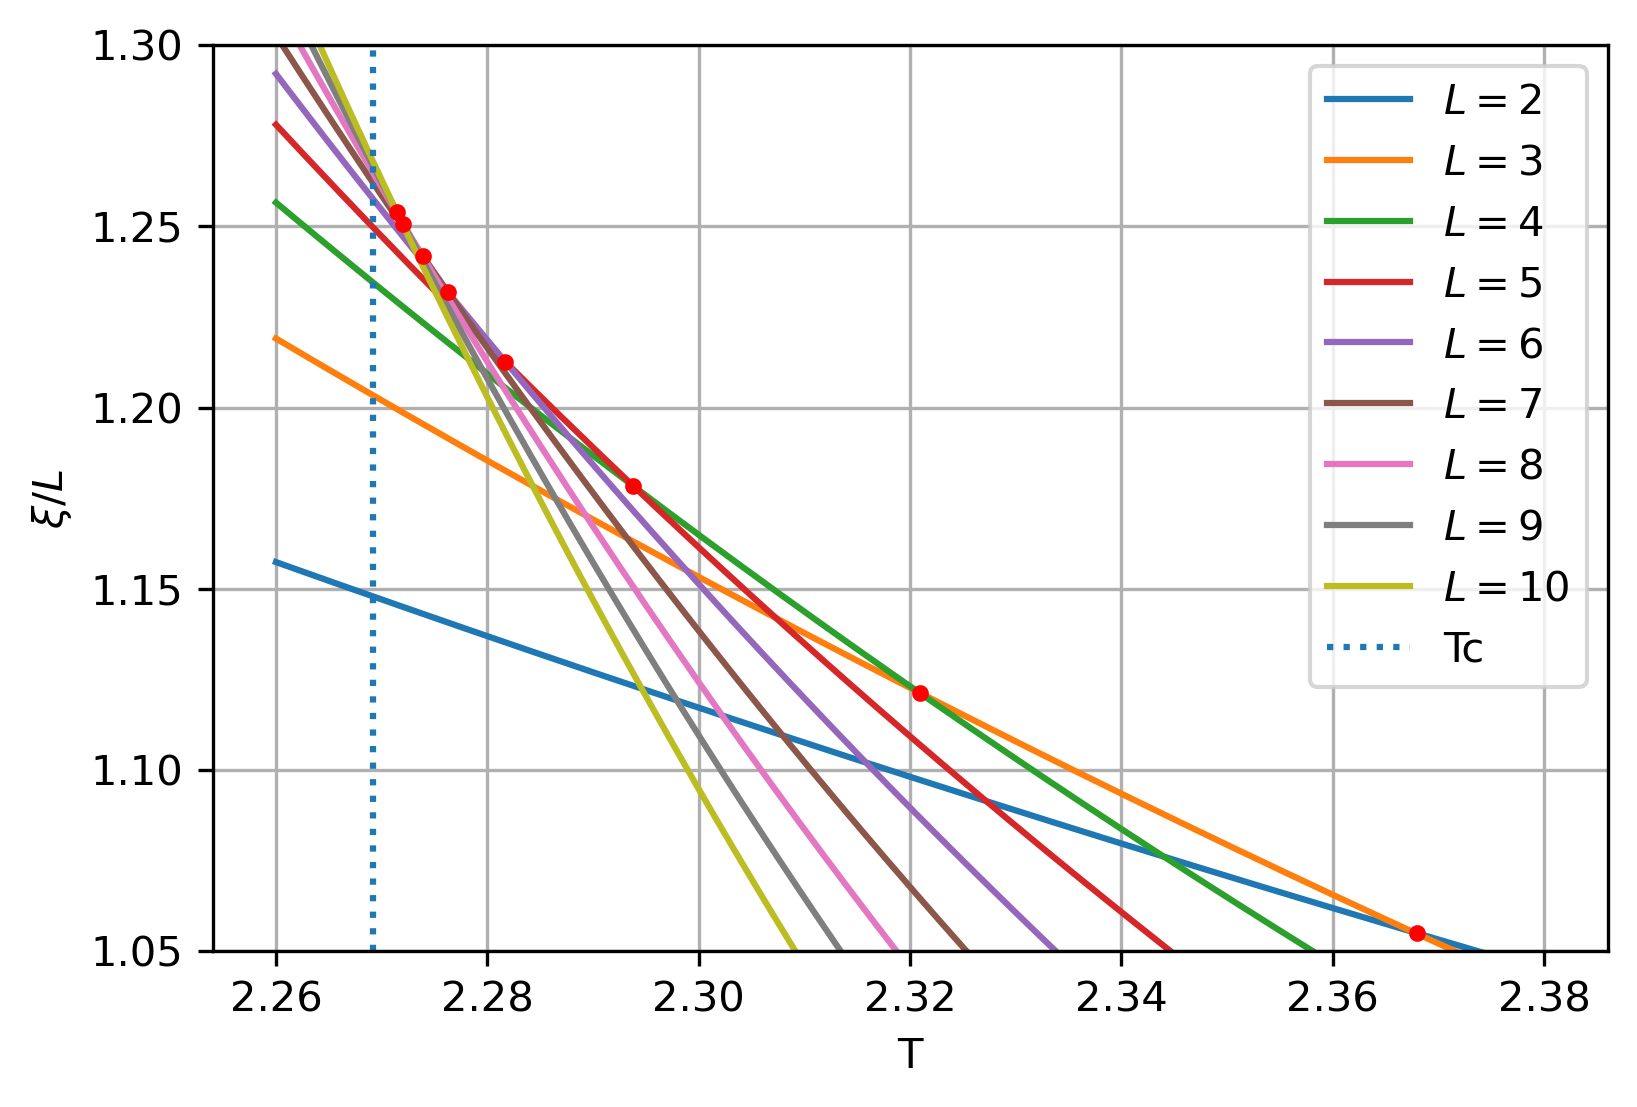

In [5]:
plt.figure(dpi = 300)
for i in range(2,MaxL+1):
    plt.plot(Temp,Corr_len[i]/i,'-',label = f'$L={i}$')
for i in range(2,MaxL):
    plt.plot(Temp[np.argmin(np.abs((Corr_len[i]/i)-(Corr_len[i+1]/(i+1))))],
             Corr_len[i][np.argmin(np.abs((Corr_len[i]/i)-(Corr_len[i+1]/(i+1))))]/i,
             '.r')
plt.axvline(x=Tc,ls=':',label = 'Tc')
plt.xlabel('T')
plt.ylabel(r'$\xi/L$')
plt.ylim((1.05,1.3))
plt.grid()
plt.legend()
plt.show()

2.3679396984924623
2.3209045226130653
2.2937688442211055
2.2817085427135675
2.276281407035176
2.2738693467336684
2.2720603015075373
2.2714572864321605


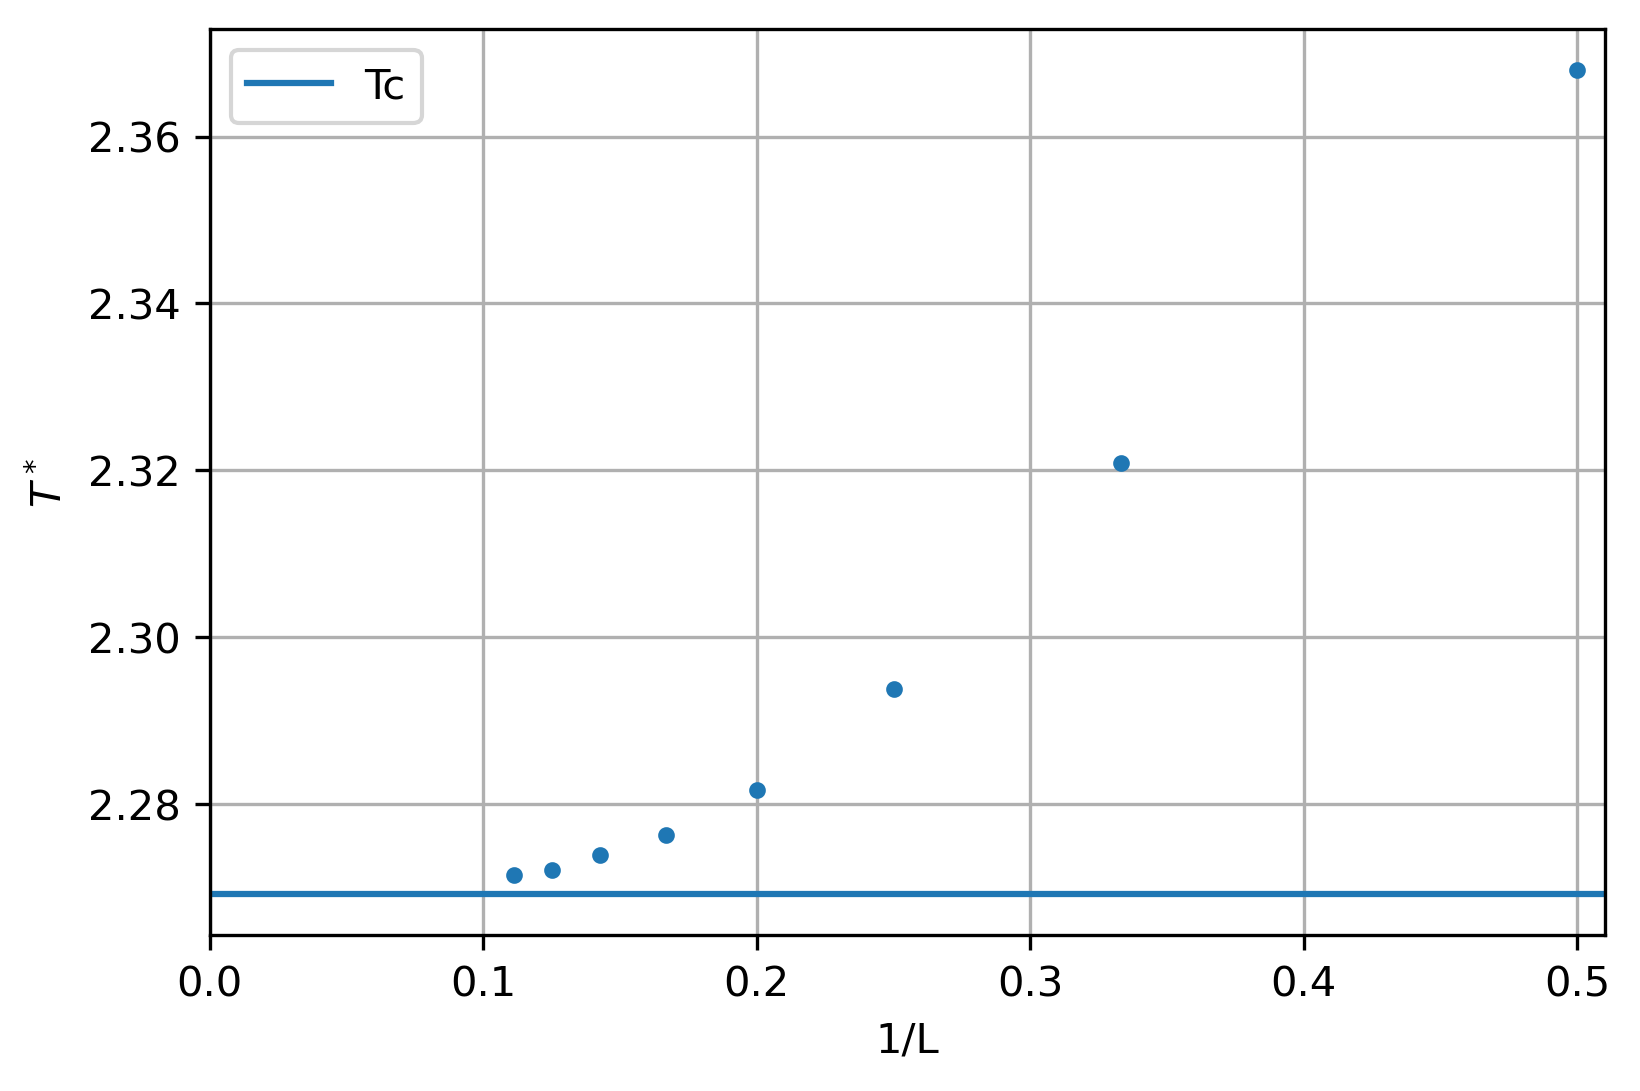

In [6]:
T_star = []
plt.figure(dpi = 300)
for i in range(2,MaxL):
    T_star.append(Temp[np.argmin(np.abs((Corr_len[i]/i)-(Corr_len[i+1]/(i+1))))])
    print(Temp[np.argmin(np.abs((Corr_len[i]/i)-(Corr_len[i+1]/(i+1))))])
plt.axhline(Tc,label = 'Tc')
plt.plot(1/np.arange(2,MaxL),T_star,'.')
#plt.axvline(x=T_star,label = '$T^*_{1,3}$')
plt.xlabel('1/L')
plt.ylabel(r'$T^*$')
plt.xlim(0,0.51)
plt.grid()
plt.legend()
plt.show()

# $N\times 2$

## MaxL = 10

In [7]:
MaxL = 10
Temp = np.linspace(2.26,2.38,100)
W = np.ones((MaxL+1,len(Temp),2))
Tc = 2/np.log(1+np.sqrt(2))

In [8]:
%%time
for i,temp in enumerate(Temp):
    #print(temp)
    T_bare = get_T_baret(temp) 
    T_bare = merge_x(T_bare,T_bare,True)
    TL =T_bare
    #ut_print(TL)
    for j in range(2,MaxL+1):
        TL_Trace = merge_y(TL,T_bare,True,True)
        w,v = cytnx.linalg.Eigh(TL_Trace.get_block())
        W[j,i,:] = w[-2:].numpy()
        TL = merge_y(TL,T_bare,True)
E = -np.log(W)/2
Corr_len = 1/(E[:,:,-2]-E[:,:,-1])

CPU times: user 47min 33s, sys: 3min 28s, total: 51min 2s
Wall time: 1min 34s


/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: divide by zero encountered in true_divide
  del sys.path[0]


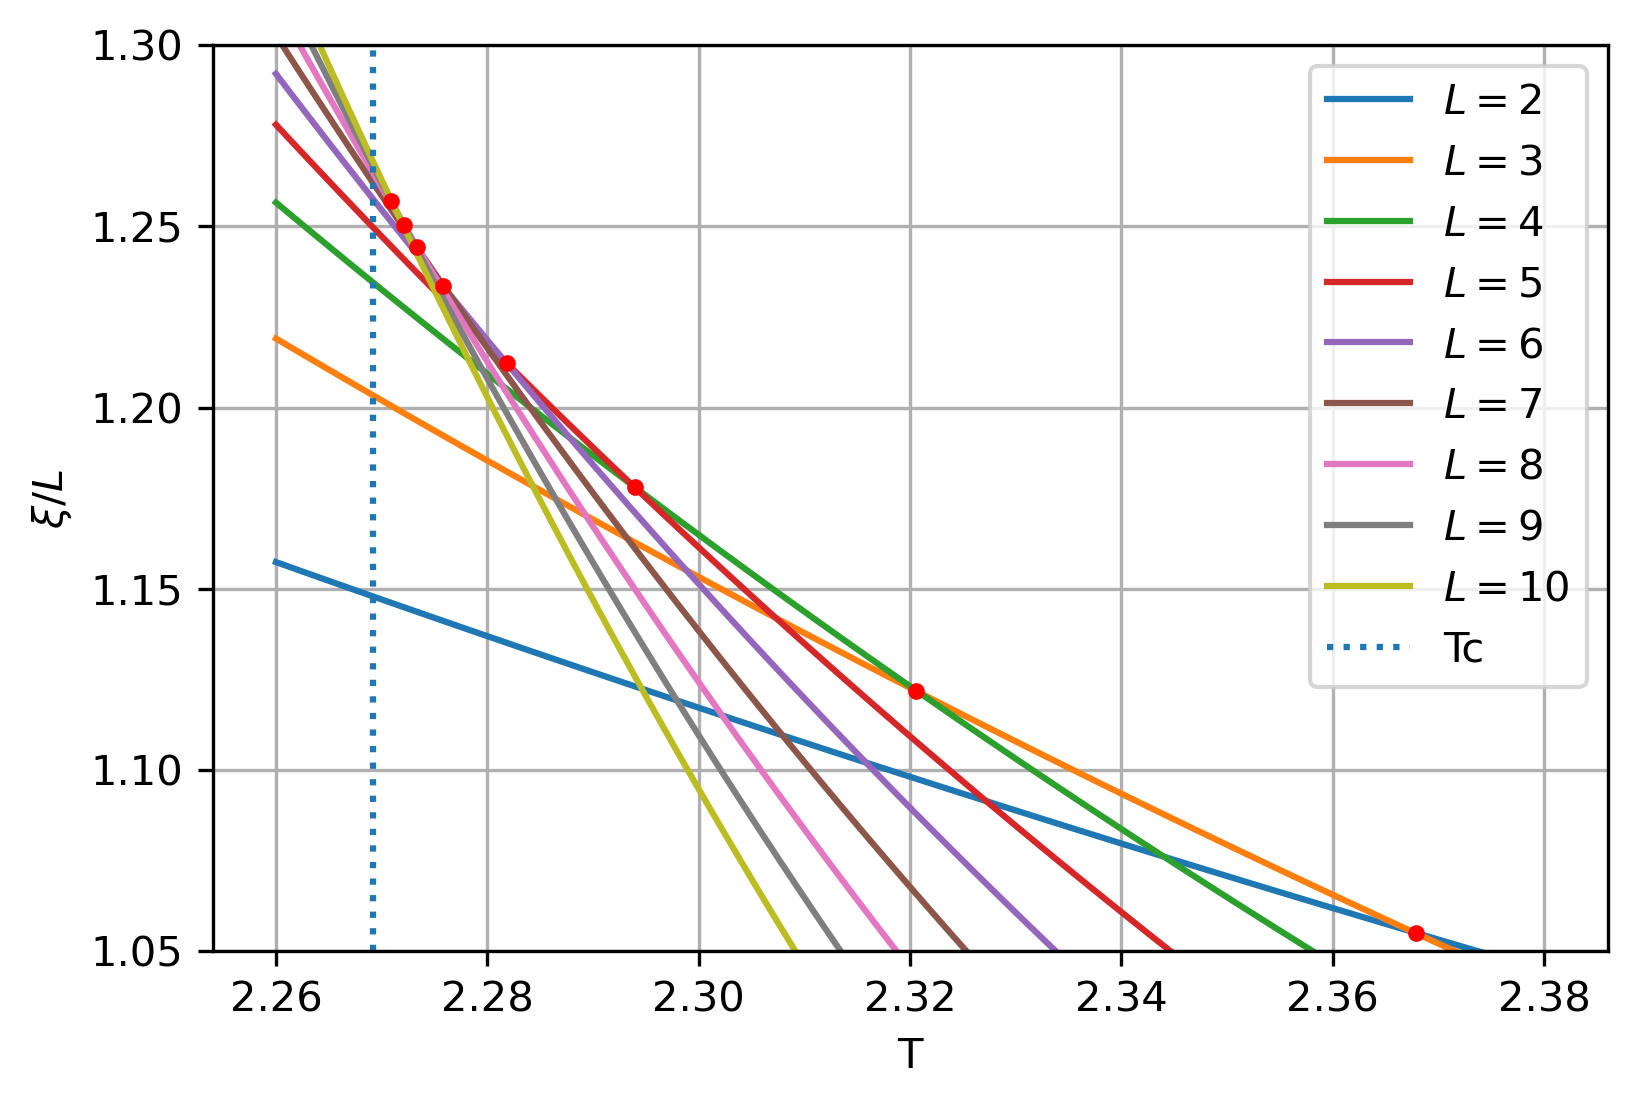

In [9]:
plt.figure(dpi = 300)
for i in range(2,MaxL+1):
    plt.plot(Temp,Corr_len[i]/i,'-',label = f'$L={i}$')
for i in range(2,MaxL):
    plt.plot(Temp[np.argmin(np.abs((Corr_len[i]/i)-(Corr_len[i+1]/(i+1))))],
             Corr_len[i][np.argmin(np.abs((Corr_len[i]/i)-(Corr_len[i+1]/(i+1))))]/i,
             '.r')
plt.axvline(x=Tc,ls=':',label = 'Tc')
plt.xlabel('T')
plt.ylabel(r'$\xi/L$')
plt.ylim((1.05,1.3))
plt.grid()
plt.legend()
plt.show()

2.3678787878787877
2.3206060606060603
2.293939393939394
2.2818181818181817
2.2757575757575754
2.273333333333333
2.272121212121212
2.2709090909090905


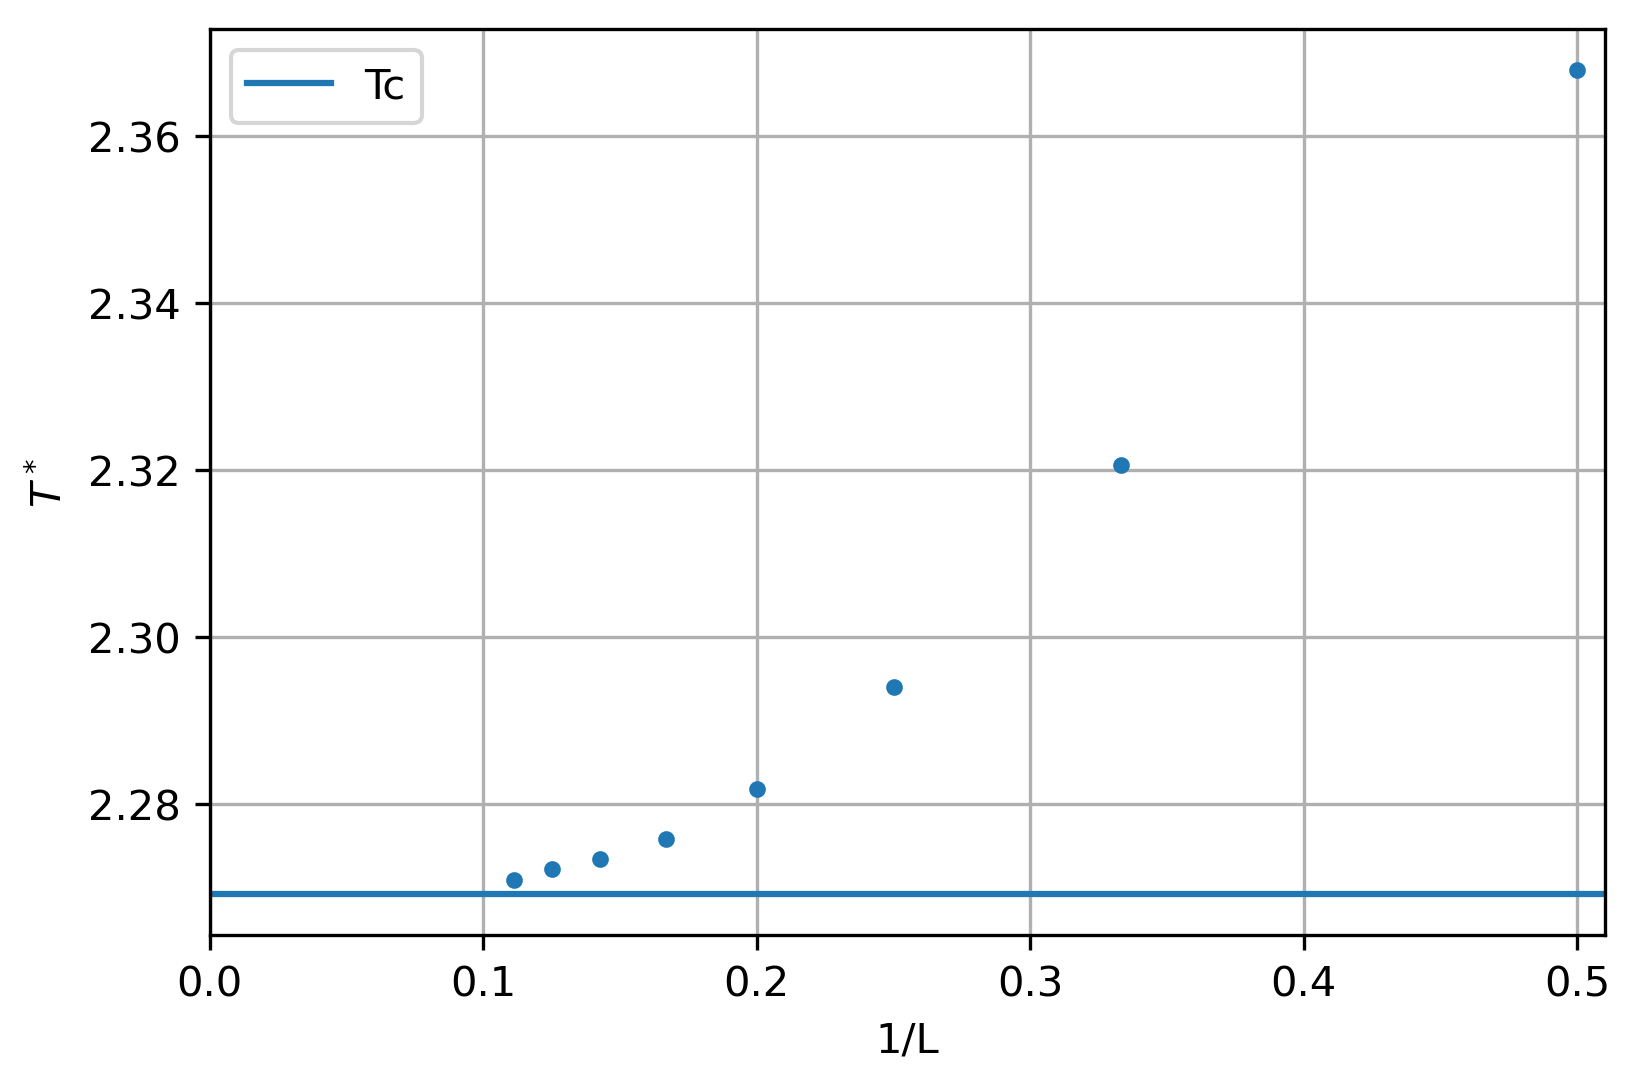

In [10]:
T_star = []
plt.figure(dpi = 300)
for i in range(2,MaxL):
    T_star.append(Temp[np.argmin(np.abs((Corr_len[i]/i)-(Corr_len[i+1]/(i+1))))])
    print(Temp[np.argmin(np.abs((Corr_len[i]/i)-(Corr_len[i+1]/(i+1))))])
plt.axhline(Tc,label = 'Tc')
plt.plot(1/np.arange(2,MaxL),T_star,'.')
#plt.axvline(x=T_star,label = '$T^*_{1,3}$')
plt.xlabel('1/L')
plt.ylabel(r'$T^*$')
plt.xlim(0,0.51)
plt.grid()
plt.legend()
plt.show()

# $N\times N$

## MaxL = $8\times 8$

In [11]:
MaxL = 4
Temp = np.linspace(2.26,2.36,20)
W = np.ones((MaxL+1,len(Temp),2))
E = np.ones((MaxL+1,len(Temp),2))
Tc = 2/np.log(1+np.sqrt(2))

In [12]:
%%time
for i,temp in enumerate(Temp):
    T_bare = get_T_baret(temp) 
    TL = T_bare
    for j in range(2,MaxL+1):
        #print(j)
        TLx = merge_x(TL,TL,True)
        TL_Trace = merge_y(TLx,TLx,True,True)
        w,v = cytnx.linalg.Eigh(TL_Trace.get_block())
        W[j,i,:] = w[-2:].numpy()
        TL = merge_y(TLx,TLx,True)
E = -np.log(W)
Corr_len = 1/(E[:,:,-2]-E[:,:,-1])

CPU times: user 1h 10min 19s, sys: 55min 48s, total: 2h 6min 8s
Wall time: 7min 25s


/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in true_divide
  if sys.path[0] == '':


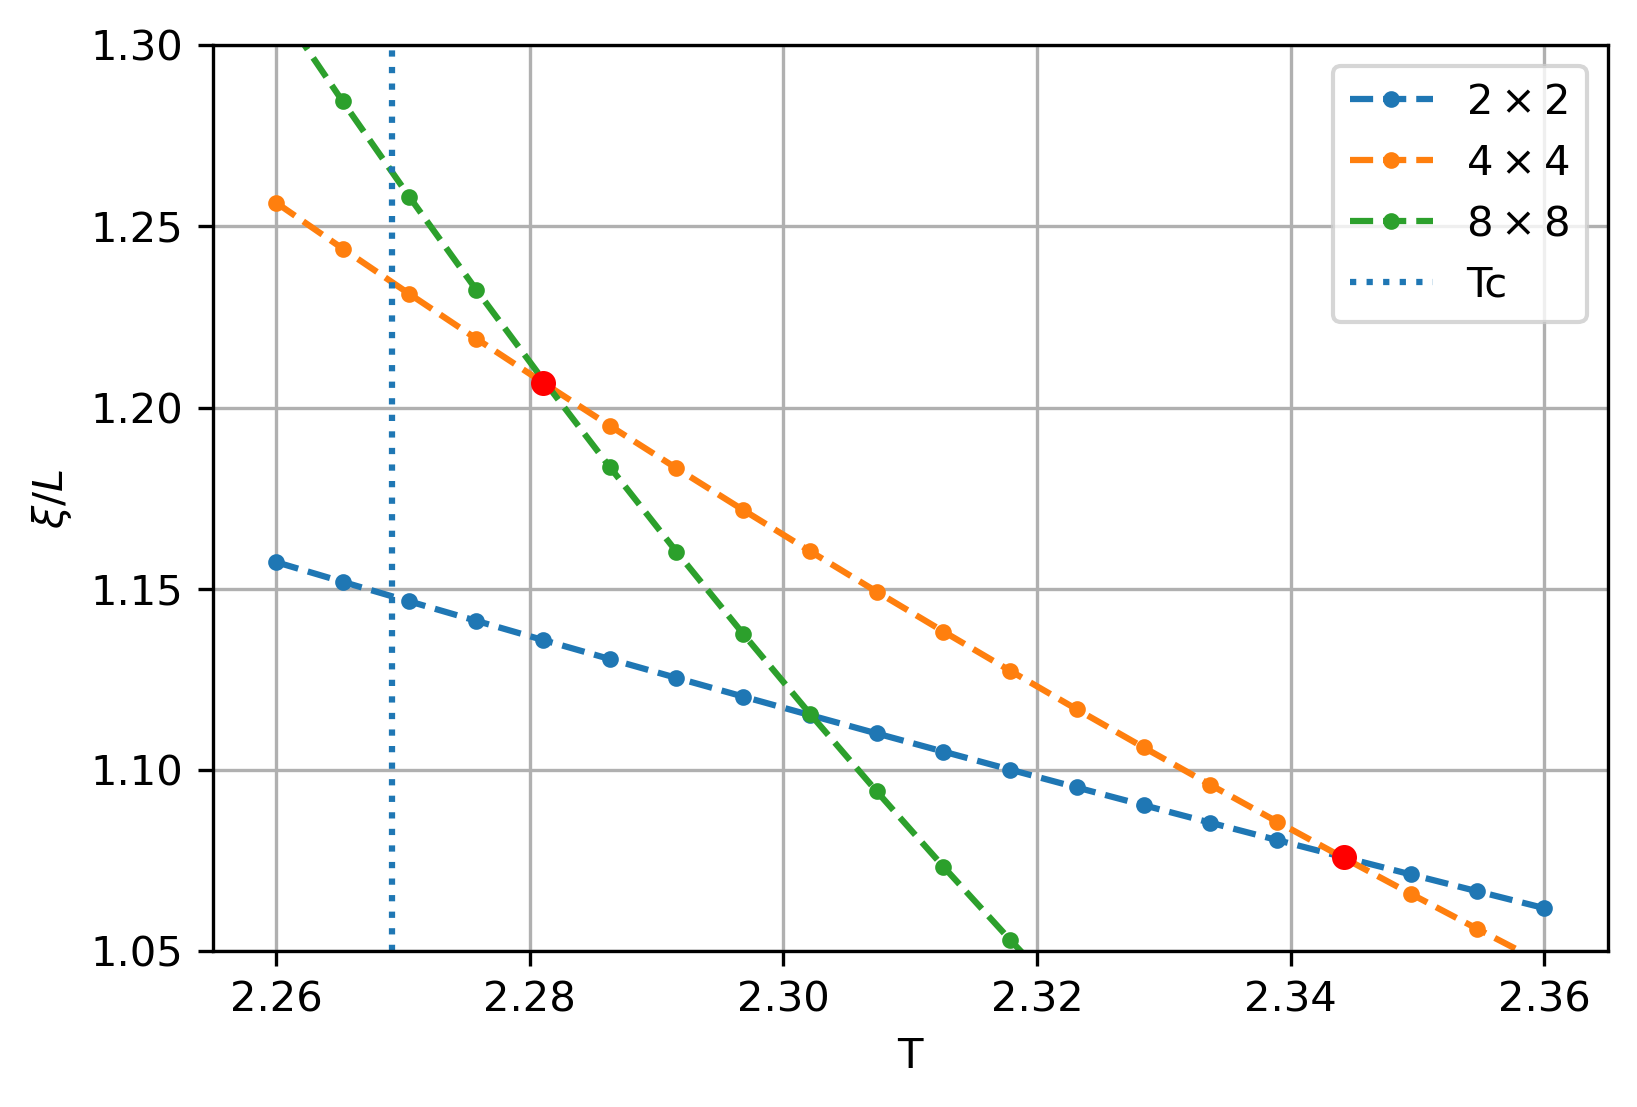

In [13]:
plt.figure(dpi = 300)
for i in range(2,MaxL+1):
    plt.plot(Temp,Corr_len[i],'.--',label = f'${2**(i-1)}\\times{2**(i-1)}$')
for i in range(2,MaxL):
    plt.plot(Temp[np.argmin(np.abs((Corr_len[i])-(Corr_len[i+1])))],
             Corr_len[i][np.argmin(np.abs((Corr_len[i])-(Corr_len[i+1])))],
             '.r',ms = 10)
plt.axvline(x=Tc,ls=':',label = 'Tc')
plt.xlabel('T')
plt.ylabel(r'$\xi/L$')
plt.ylim((1.05,1.3))
plt.grid()
plt.legend()
plt.show()

In [14]:
MaxL = 4
Temp1 = np.linspace(2.26,2.36,100)
W1 = np.ones((MaxL+1,len(Temp1),2))
E1 = np.ones((MaxL+1,len(Temp1),2))
Tc = 2/np.log(1+np.sqrt(2))

In [15]:
%%time
for i,temp in enumerate(Temp1):
    #print(temp)
    T_bare = get_T_baret(temp)
    TL = T_bare
    for j in range(2,MaxL+1):
        TL_Trace = merge_y(TL,TL,True,True)
        w,v = cytnx.linalg.Eigh(TL_Trace.get_block())
        W1[j,i,:] = w[-2:].numpy()
        TL = merge_y(TL,TL,True)
E1 = -np.log(W1)
Corr_len1 = 1/(E1[:,:,-2]-E1[:,:,-1])

CPU times: user 2min 57s, sys: 11.1 s, total: 3min 8s
Wall time: 7.48 s


/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


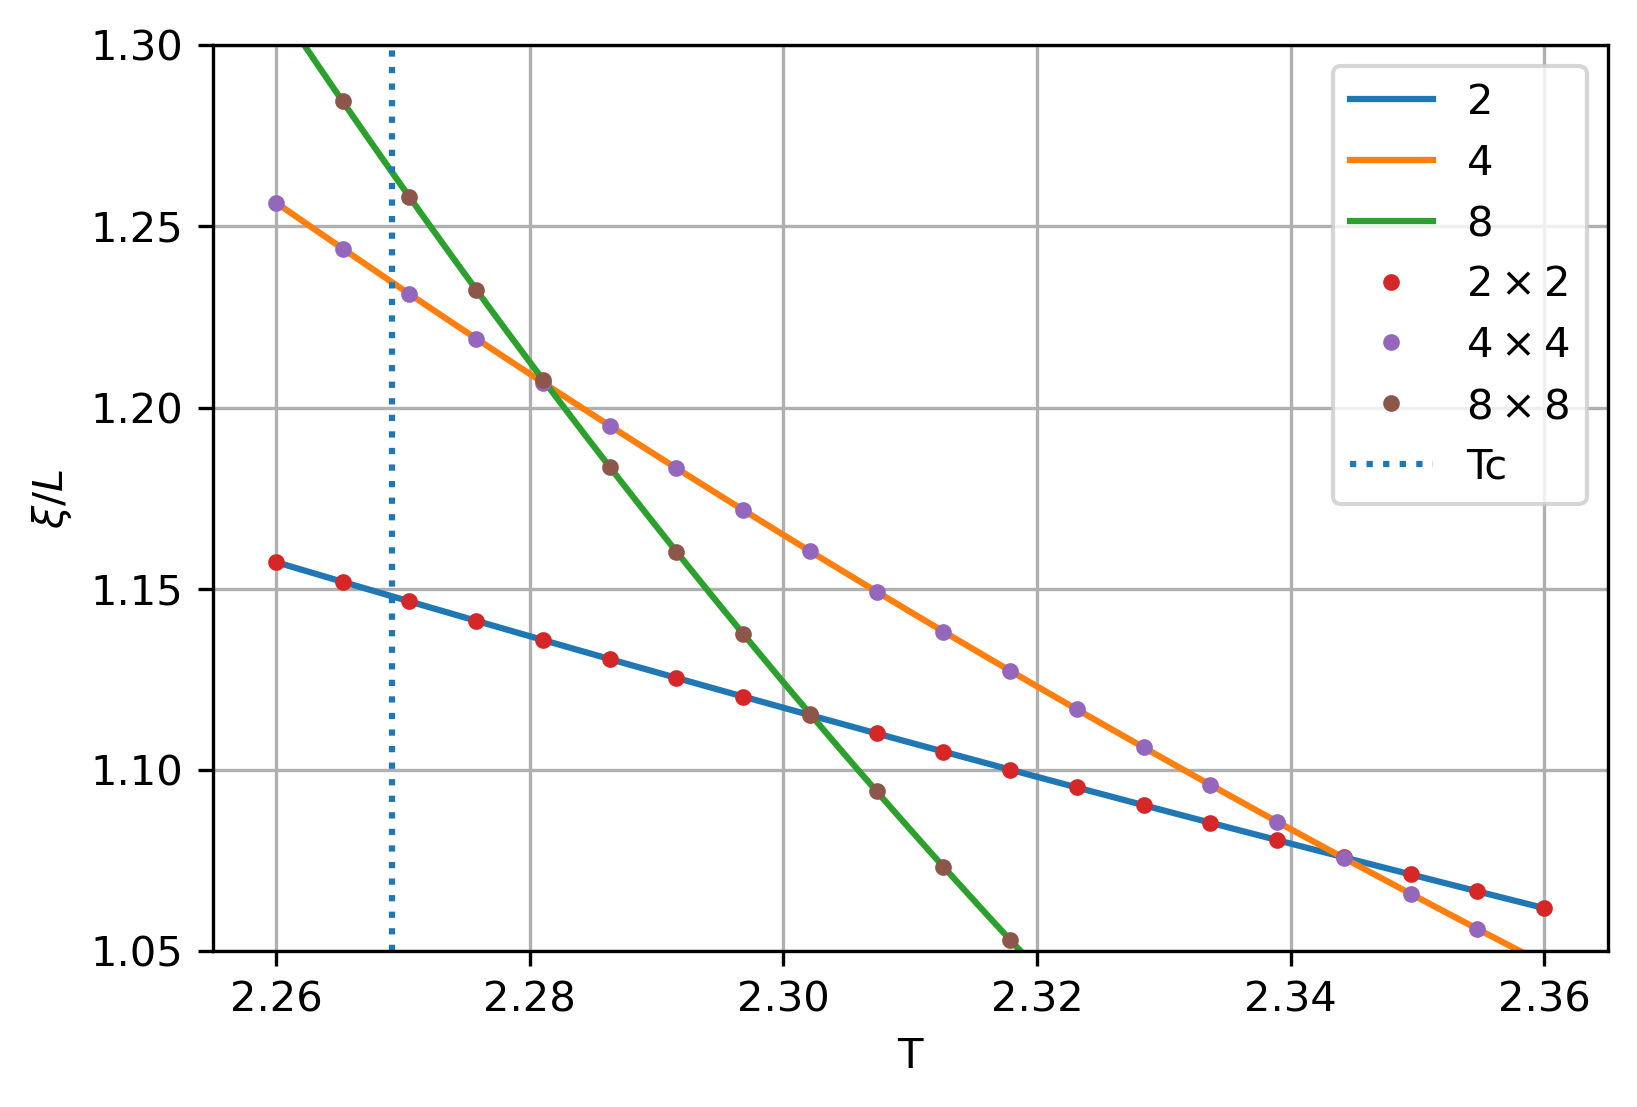

In [16]:
plt.figure(dpi = 300)
for i in range(2,MaxL+1):
    plt.plot(Temp1,Corr_len1[i]/2**(i-1),'-',label = f'${2**(i-1)}$')
for i in range(2,MaxL+1):
    plt.plot(Temp,Corr_len[i],'.',label = f'${2**(i-1)}\\times{2**(i-1)}$')
plt.axvline(x=Tc,ls=':',label = 'Tc')
plt.xlabel('T')
plt.ylabel(r'$\xi/L$')
plt.ylim((1.05,1.3))
plt.grid()
plt.legend()
plt.show()

# Fit curve

In [17]:
MaxL = 10
Temp = np.linspace(2.26,2.36,200)
W = np.ones((MaxL+1,len(Temp),2))
Tc = 2/np.log(1+np.sqrt(2))

In [18]:
%%time
for i,temp in enumerate(Temp):
    #print(temp)
    T_bare = get_T_baret(temp)
    TL = T_bare
    for j in range(2,MaxL+1):
        TL_Trace = merge_y(TL,T_bare,True,True)
        w,v = cytnx.linalg.Eigh(TL_Trace.get_block())
        W[j,i,:] = w[-2:].numpy()
        TL = merge_y(TL,T_bare,True)
E = -np.log(W)
Corr_len = 1/(E[:,:,-2]-E[:,:,-1])

CPU times: user 1h 10min 7s, sys: 4min 4s, total: 1h 14min 11s
Wall time: 2min 23s


/home/TCC0731/anaconda3/envs/cytnx/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


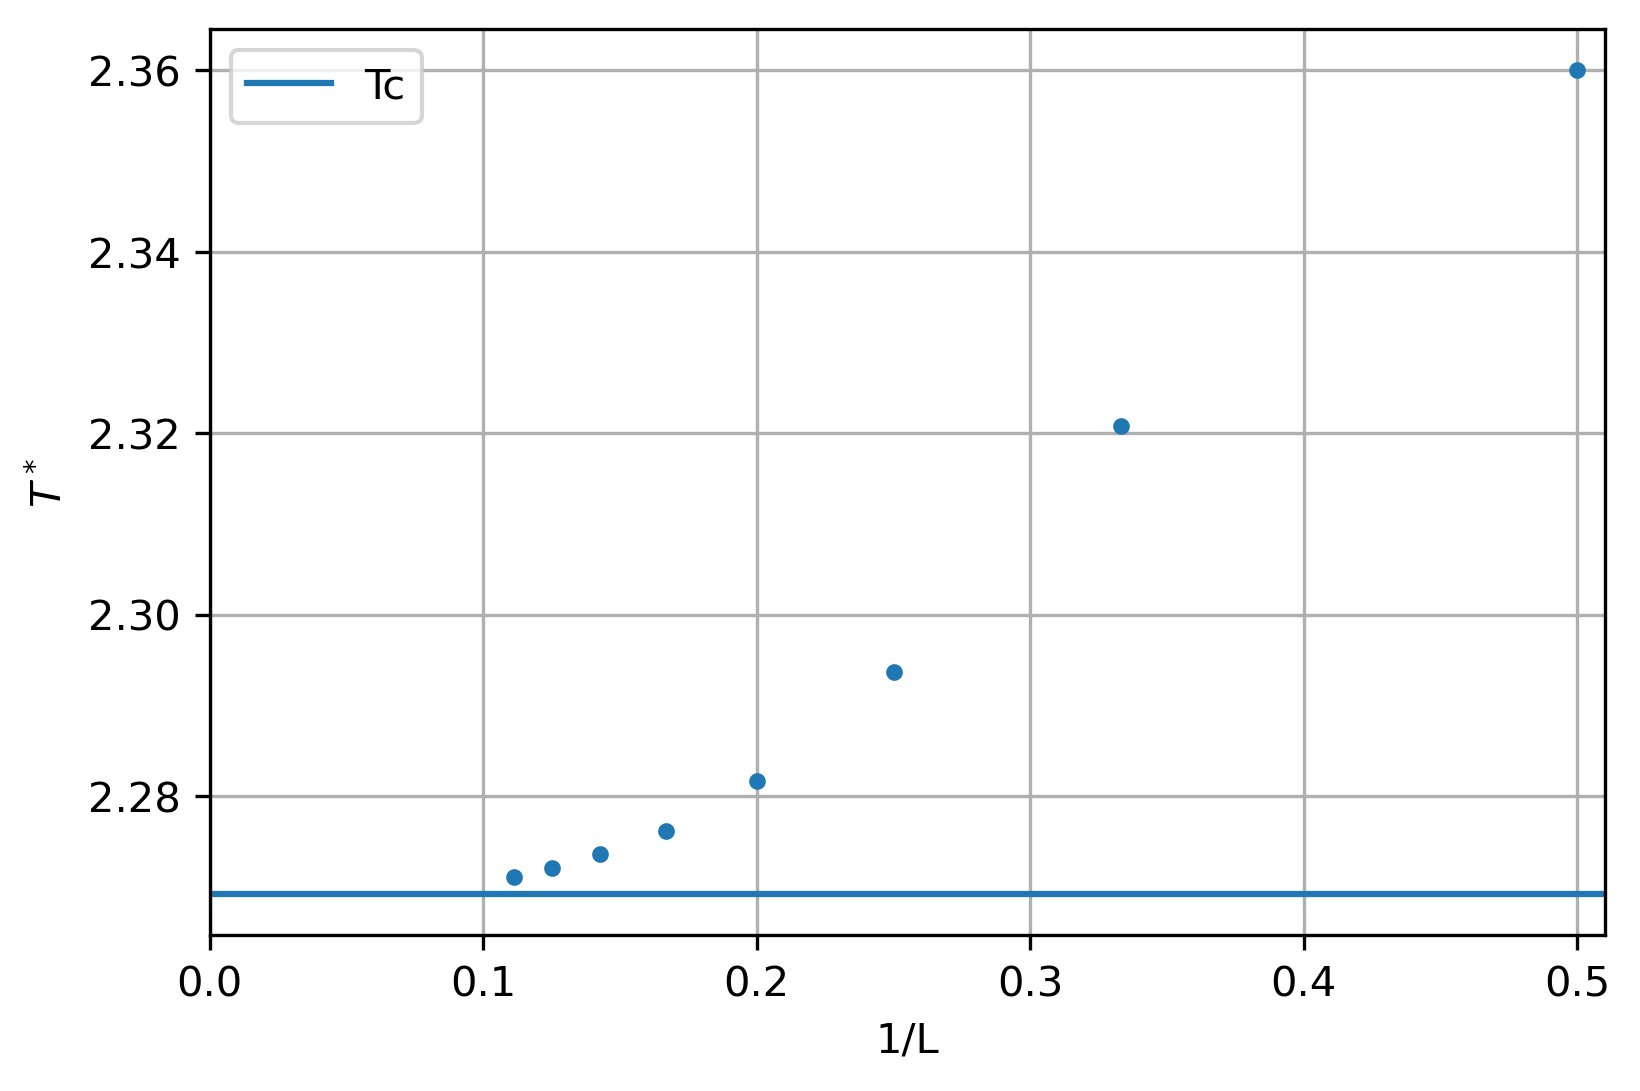

In [19]:
T_star = []
plt.figure(dpi = 300)
for i in range(2,MaxL):
    T_star.append(Temp[np.argmin(np.abs((Corr_len[i]/i)-(Corr_len[i+1]/(i+1))))])
    #print(Temp[np.argmin(np.abs((Corr_len[i]/i)-(Corr_len[i+1]/(i+1))))])
plt.axhline(Tc,label = 'Tc')
plt.plot(1/np.arange(2,MaxL),T_star,'.')
#plt.axvline(x=T_star,label = '$T^*_{1,3}$')
plt.xlabel('1/L')
plt.ylabel(r'$T^*$')
plt.xlim(0,0.51)
plt.grid()
plt.legend()
plt.show()

In [20]:
def func(x, tc, A, B):
    return tc + A * (x**B)
popt, pcov = curve_fit(func, 1/np.arange(2,MaxL),T_star)

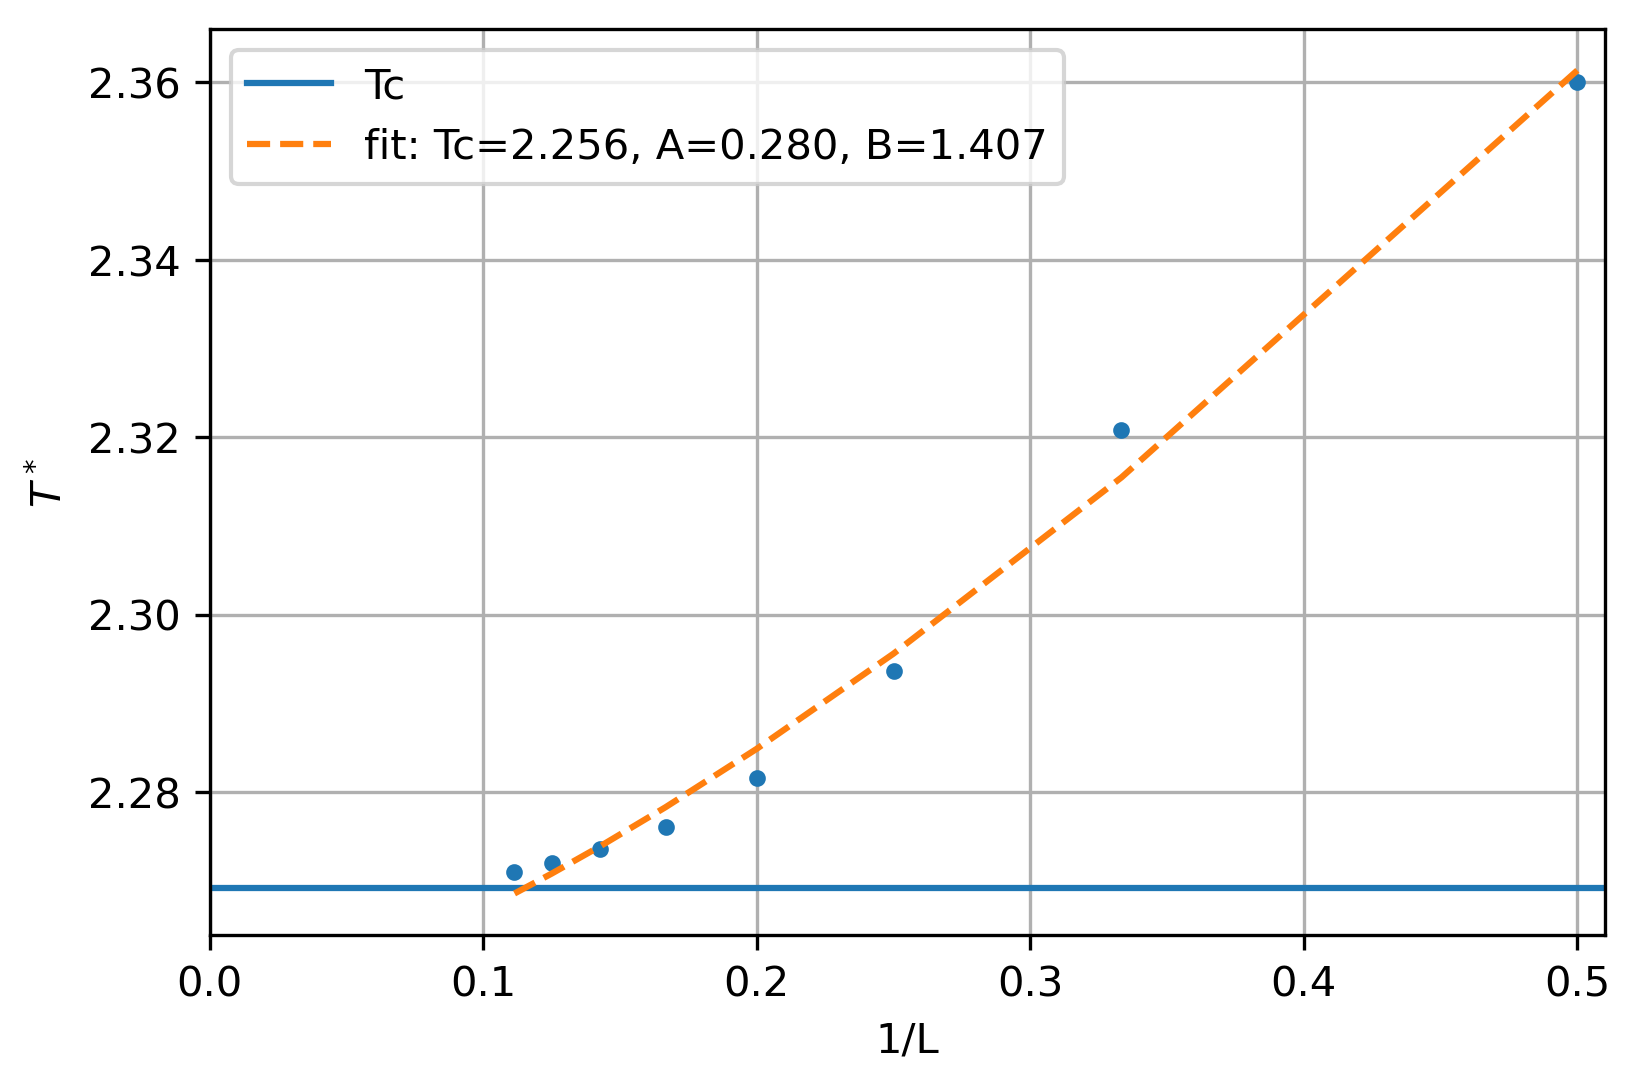

In [21]:
plt.figure(dpi = 300)
plt.axhline(Tc,label = 'Tc')
plt.plot(1/np.arange(2,MaxL),T_star,'.')
plt.plot(1/np.arange(2,MaxL), func(1/np.arange(2,MaxL), *popt), '--',
         label='fit: Tc=%5.3f, A=%5.3f, B=%5.3f' % tuple(popt))
plt.xlabel('1/L')
plt.ylabel(r'$T^*$')
plt.xlim(0,0.51)
plt.grid()
plt.legend()
plt.show()